In [2]:
import pandas as pd

# Read the Label.csv file
labels = pd.read_csv('../data/CICD/Label.csv')
# Read the Data.csv file
data = pd.read_csv('../data/CICD/Data.csv')


In [3]:
#Train/test split
from sklearn.model_selection import train_test_split

# Create X (features) and y (target)
X = data
y = labels['Label']

# Create train/test split with 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Print the shapes of the resulting splits
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)
print("Training labels shape:", y_train.shape)
print("Testing labels shape:", y_test.shape)

Training set shape: (358332, 76)
Testing set shape: (89583, 76)
Training labels shape: (358332,)
Testing labels shape: (89583,)


In [4]:
# Check for potential categorical features
categorical_like = []
numerical_features = []

for column in data.columns:
    # Check number of unique values
    n_unique = data[column].nunique()
    
    # If number of unique values is small (less than 10), it might be categorical
    if n_unique < 10:
        categorical_like.append({
            'column': column,
            'unique_values': sorted(data[column].unique()),
            'count': n_unique
        })
    else:
        numerical_features.append(column)

# Print potential categorical features
print("Potential categorical features:")
for feat in categorical_like:
    print(f"\n{feat['column']}:")
    print(f"Number of unique values: {feat['count']}")
    print(f"Unique values: {feat['unique_values']}")

print(f"\nNumber of numerical features: {len(numerical_features)}")

Potential categorical features:

Fwd PSH Flags:
Number of unique values: 2
Unique values: [np.int64(0), np.int64(1)]

Bwd PSH Flags:
Number of unique values: 1
Unique values: [np.int64(0)]

Fwd URG Flags:
Number of unique values: 1
Unique values: [np.int64(0)]

Bwd URG Flags:
Number of unique values: 1
Unique values: [np.int64(0)]

FIN Flag Count:
Number of unique values: 4
Unique values: [np.int64(0), np.int64(1), np.int64(2), np.int64(3)]

SYN Flag Count:
Number of unique values: 9
Unique values: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(6), np.int64(8), np.int64(10), np.int64(12)]

RST Flag Count:
Number of unique values: 2
Unique values: [np.int64(0), np.int64(1)]

URG Flag Count:
Number of unique values: 1
Unique values: [np.int64(0)]

CWR Flag Count:
Number of unique values: 1
Unique values: [np.int64(0)]

ECE Flag Count:
Number of unique values: 1
Unique values: [np.int64(0)]

Down/Up Ratio:
Number of unique values: 9
Unique values: [np.float64(0

In [5]:
from sklearn.preprocessing import StandardScaler, RobustScaler
import numpy as np

# Create copy of data to avoid modifying original
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

# Separate numerical features that need scaling
# Exclude categorical-like features and flags
features_to_scale = [col for col in X_train.columns if col not in [f['column'] for f in categorical_like]]

# Create scalers
standard_scaler = StandardScaler()
robust_scaler = RobustScaler()

# Apply log transformation to highly skewed features with large ranges
skewed_features = ['Flow Duration', 'Flow Bytes/s', 'Flow Packets/s', 
                  'Flow IAT Mean', 'Flow IAT Max', 'Packet Length Variance']

for feature in skewed_features:
    # Add small constant to handle zeros
    X_train_scaled[feature] = np.log1p(X_train_scaled[feature].replace(0, 1e-6))
    X_test_scaled[feature] = np.log1p(X_test_scaled[feature].replace(0, 1e-6))

# Apply robust scaling to features with outliers
outlier_features = ['Packet Length Max', 'Fwd Packet Length Max', 
                   'Bwd Packet Length Max', 'Flow IAT Std']

# Fit on training data and transform both training and test data
X_train_scaled[outlier_features] = robust_scaler.fit_transform(X_train_scaled[outlier_features])
X_test_scaled[outlier_features] = robust_scaler.transform(X_test_scaled[outlier_features])

# Apply standard scaling to remaining numerical features
remaining_features = [f for f in features_to_scale 
                     if f not in skewed_features + outlier_features]

# Fit on training data and transform both training and test data
X_train_scaled[remaining_features] = standard_scaler.fit_transform(X_train_scaled[remaining_features])
X_test_scaled[remaining_features] = standard_scaler.transform(X_test_scaled[remaining_features])

print("Features scaled successfully")
print(f"Number of features transformed: {len(features_to_scale)}")

Features scaled successfully
Number of features transformed: 61


In [6]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from time import time


# Expand models and parameter grids to include more classifiers

# Update models dictionary with new classifiers
models = {
    #'Decision Tree': DecisionTreeClassifier(max_depth=20, class_weight='balanced', random_state=42),
    #'KNN': KNeighborsClassifier(n_jobs=-1),
    #'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced', n_jobs=-1, random_state=42),
    'Random Forest': RandomForestClassifier(n_jobs=-1, class_weight='balanced', random_state=42)
    #'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    #'Linear SVC': LinearSVC(random_state=42, max_iter=2000)
}

# Update parameter grids for all models
param_grids = {
    'Decision Tree': {
        'max_depth': [10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'class_weight': ['balanced']
    },
    'KNN': {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance'],
        'p': [1, 2]
    },
    'Logistic Regression': {
        'C': [0.1, 1.0, 10.0],
        'solver': ['lbfgs', 'liblinear'],
        'class_weight': ['balanced']
    },
    'Random Forest': {
        'n_estimators': [50, 100],
        'max_depth': [10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'class_weight': ['balanced']
    },
    'Gradient Boosting': {
        'n_estimators': [50, 100],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5]
    },
    'Linear SVC': {
        'C': [0.1, 1.0, 10.0],
        'class_weight': ['balanced'],
        'dual': [False]
    }
}

# Dictionary to store best models
best_models = {}

# Perform GridSearch for each model
for name, model in models.items():
    print(f"\nPerforming GridSearch for {name}...")
    start_time = time()
    
    # Create GridSearch object
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grids[name],
        cv=5,
        n_jobs=-1,
        scoring='accuracy',
        verbose=1
    )
    
    # Fit GridSearch
    grid_search.fit(X_train_scaled, y_train)
    
    # Make predictions with best model
    y_pred = grid_search.predict(X_test_scaled)
    
    # Store results
    best_models[name] = {
        'best_params': grid_search.best_params_,
        'best_score': grid_search.best_score_,
        'test_accuracy': accuracy_score(y_test, y_pred),
        'training_time': time() - start_time,
        'report': classification_report(y_test, y_pred)
    }
    
    print(f"\n{name} Best Results:")
    print(f"Best parameters: {best_models[name]['best_params']}")
    print(f"Best cross-validation score: {best_models[name]['best_score']:.4f}")
    print(f"Test accuracy: {best_models[name]['test_accuracy']:.4f}")
    print(f"Training time: {best_models[name]['training_time']:.2f} seconds")
    print("\nClassification Report:")
    print(best_models[name]['report'])


Performing GridSearch for Random Forest...
Fitting 5 folds for each of 36 candidates, totalling 180 fits


/home/ecerocg/ML-IDS/.venv/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



Random Forest Best Results:
Best parameters: {'class_weight': 'balanced', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation score: 0.9314
Test accuracy: 0.9324
Training time: 1905.22 seconds

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     71666
           1       0.28      0.99      0.44        77
           2       0.80      0.54      0.65        90
           3       0.62      0.34      0.44       894
           4       0.84      0.74      0.79      6190
           5       0.59      0.91      0.72      5923
           6       0.85      0.76      0.80       927
           7       0.80      0.69      0.74      3347
           8       0.37      0.42      0.39       420
           9       0.34      0.47      0.39        49

    accuracy                           0.93     89583
   macro avg       0.65      0.68      0.64     89583
weighted avg       0.94

In [10]:
# FINAL training with Random Forest

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Create and train Random Forest with class weights to handle imbalance
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=2,
    min_samples_leaf=1,
    class_weight='balanced',
    n_jobs=-1,
    random_state=42
)

# Train the model
rf_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = rf_model.predict(X_test_scaled)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Get feature importance
feature_importance = pd.DataFrame({
    'feature': data.columns,
    'importance': rf_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Print top 10 most important features
print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     71666
           1       0.28      0.99      0.44        77
           2       0.80      0.54      0.65        90
           3       0.62      0.34      0.44       894
           4       0.84      0.74      0.79      6190
           5       0.59      0.91      0.72      5923
           6       0.85      0.76      0.80       927
           7       0.80      0.69      0.74      3347
           8       0.37      0.42      0.39       420
           9       0.34      0.47      0.39        49

    accuracy                           0.93     89583
   macro avg       0.65      0.68      0.64     89583
weighted avg       0.94      0.93      0.94     89583


Top 10 Most Important Features:
                       feature  importance
3   Total Length of Fwd Packet    0.054250
5        Fwd Packet Length Max    0.050878
38           Packet Length Max    0.045911
36           

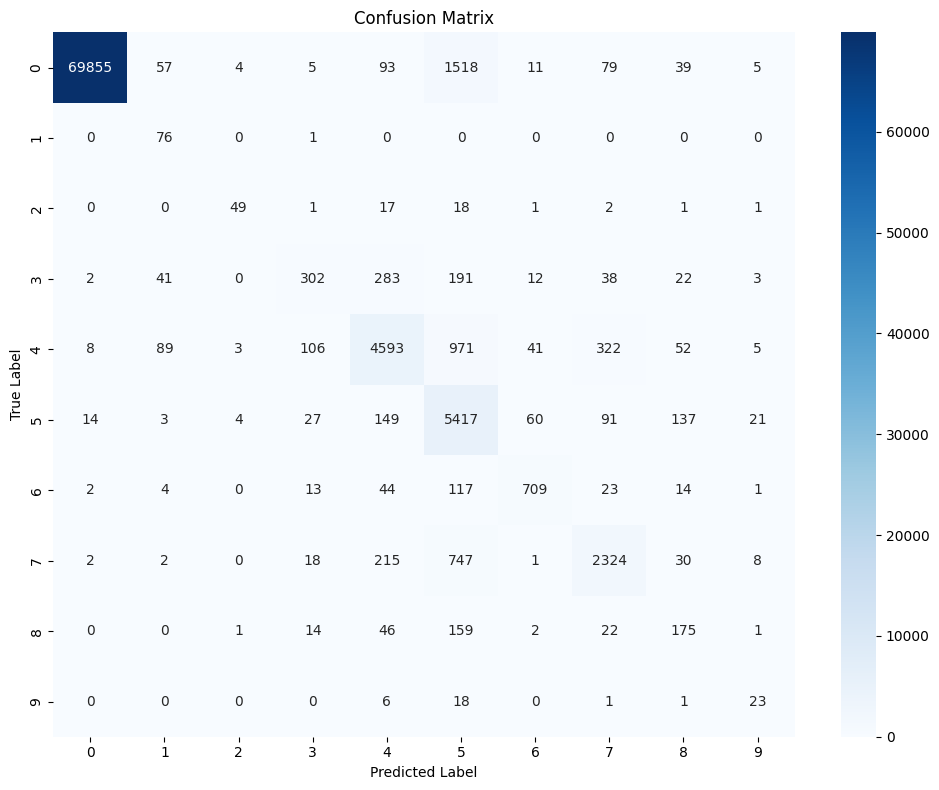


Overall Accuracy: 93.24%
Class 0 Accuracy: 97.47%
Class 1 Accuracy: 98.70%
Class 2 Accuracy: 54.44%
Class 3 Accuracy: 33.78%
Class 4 Accuracy: 74.20%
Class 5 Accuracy: 91.46%
Class 6 Accuracy: 76.48%
Class 7 Accuracy: 69.44%
Class 8 Accuracy: 41.67%
Class 9 Accuracy: 46.94%


In [11]:
#Confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

import matplotlib.pyplot as plt

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Add labels
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.tight_layout()
plt.show()

# Calculate and print overall accuracy
accuracy = (cm.diagonal().sum() / cm.sum()) * 100
print(f"\nOverall Accuracy: {accuracy:.2f}%")

# Calculate per-class accuracy
per_class_accuracy = (cm.diagonal() / cm.sum(axis=1)) * 100
for i, acc in enumerate(per_class_accuracy):
    print(f"Class {i} Accuracy: {acc:.2f}%")

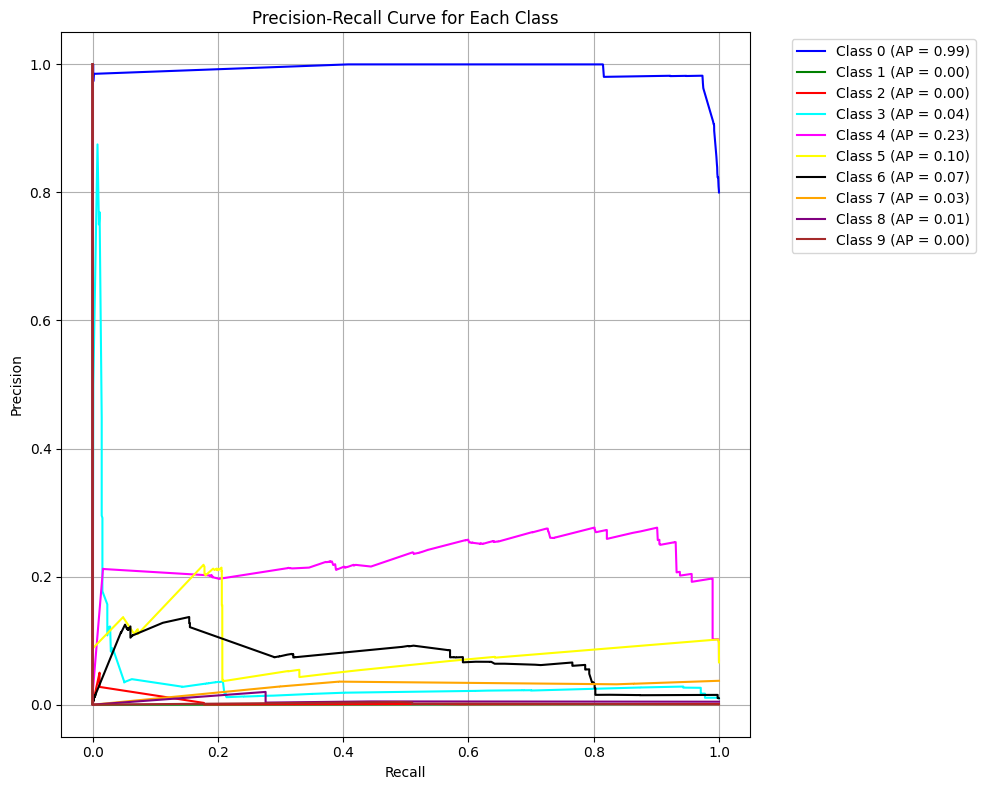

In [9]:
# Calculate precision-recall curve for each class
from sklearn.metrics import precision_recall_curve, average_precision_score

import matplotlib.pyplot as plt

# Get prediction probabilities for each class
y_scores = rf_model.predict_proba(X_test)

# Calculate precision-recall curve for each class
plt.figure(figsize=(10, 8))
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'orange', 'purple', 'brown']

for i in range(10):  # 10 classes (0-9)
    precision, recall, _ = precision_recall_curve(y_test == i, y_scores[:, i])
    avg_precision = average_precision_score(y_test == i, y_scores[:, i])
    
    plt.plot(recall, precision, color=colors[i], 
             label=f'Class {i} (AP = {avg_precision:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Each Class')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()